## Generation of GMM test dataset

Draft code towards `models.single_mouse_gmm.test_data`

### Setup

In [1]:
%load_ext autoreload
%autoreload 3 --print

In [38]:
import kpsn.models.single_mouse_gmm.model as smgmm
import kpsn.models.single_mouse_gmm.test_data as smgmm_test
from mph.generative.test.visualize import mixtures
import jax.numpy as jnp
import jax.random as jr
import jax.nn as jnn

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.markers
import matplotlib.colors

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Drafting

In [75]:
class StatefulPRNGKey:
    def __init__(self, seed): self._key = jr.PRNGKey(seed)
    def split(self, n):
        k = jr.split(self._key, n)
        self._key = k[0]
        return k[1:] if n > 2 else k[1]
model_seed = StatefulPRNGKey(0)

arch = smgmm.SingleMouseGMMArch(
    N = 5, M = 2, T = 100
)
pi_logit_means = 2 * jnp.ones(arch.N)
pi_logit_stds = 0.06 * jnp.ones(arch.N)
pi_logits = jr.multivariate_normal(
    model_seed.split(2),
    pi_logit_means, jnp.diag(pi_logit_stds))
pi = jnn.softmax(pi_logits)

m_spread = 2
m_spread_std = 0.4
m_direction = jr.multivariate_normal(
    model_seed.split(2),
    jnp.zeros(arch.M), jnp.diag(jnp.ones(arch.M)),
    shape = (arch.N,)
)
m_norm = jnp.exp(m_spread + m_spread_std * jr.normal(
    model_seed.split(2),
    shape = (arch.N,)
))
m = m_direction * m_norm[:, None] / jnp.linalg.norm(m_direction, axis = 1)[:, None]

q_sigma_center = 0.5
q_sigma_spread = 0.5
q_sigma = jnp.exp(q_sigma_center * q_sigma_spread * jr.normal(
    model_seed.split(2),
    shape = (arch.N, arch.M),
))
Q = jnp.zeros([arch.N, arch.M, arch.M])
Q = Q.at[:, jnp.arange(arch.M), jnp.arange(arch.M)].set(q_sigma)

z = jr.choice(
    model_seed.split(2),
    arch.N,
    shape = (arch.T,),
    replace = True,
    p = pi
)

x = jr.multivariate_normal(
    model_seed.split(2),
    m[z], Q[z],
)

eps = 0.05
y = x + eps * jr.normal(
    model_seed.split(2),
    shape = (arch.T, arch.M)
)
latents = smgmm.SingleMouseGMMLatents(z, x)
observables = smgmm.SingleMouseGMMObservables(y)
theta = smgmm.SingleMouseGMMParameters(pi, m, Q)


### Usage

In [8]:
arch = smgmm_test.ExampleSMGMMArch
hyperparams, latents, observables, theta = smgmm_test.sample(
    jr.PRNGKey(1),
    arch,
    smgmm_test.ExampleSMGMMHyperparams,
    **smgmm_test.ExampleSMGMMDatasetParams
)

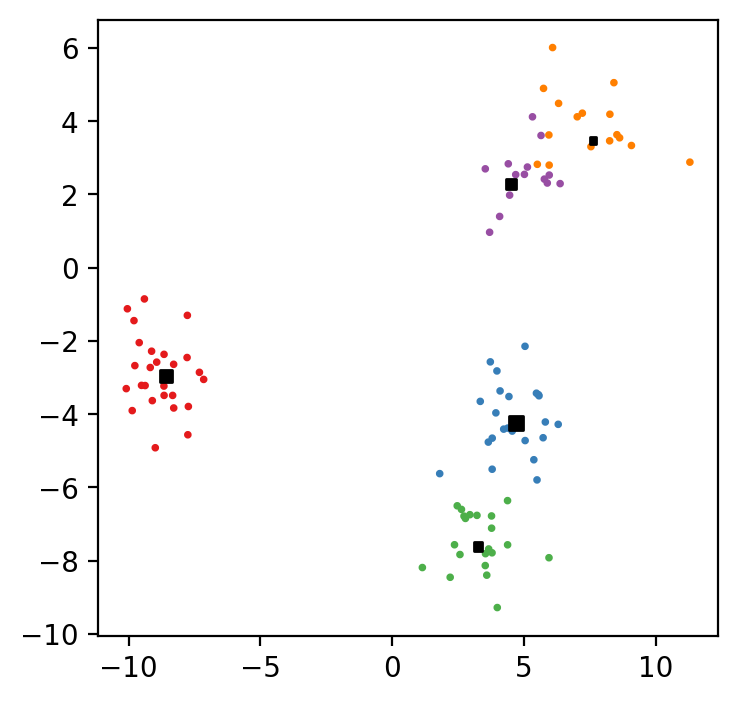

In [10]:

pal = jnp.array(sns.color_palette("Set1", n_colors = arch.N))

fig, ax = plt.subplots(figsize = (4, 4))
ax.scatter(
    observables.y[:, 0], observables.y[:, 1],
    c = pal[latents.z],
    s = 3
)

size_norm = matplotlib.colors.Normalize(vmin = theta.pi().min(), vmax = theta.pi().max())
ax.scatter(
    theta.m[:, 0], theta.m[:, 1],
    color = 'k', s = size_norm(theta.pi()) * 20 + 5,
    marker = "s"
)

plt.show()

Reloading 'mph.generative.test.visualize.mixtures'.


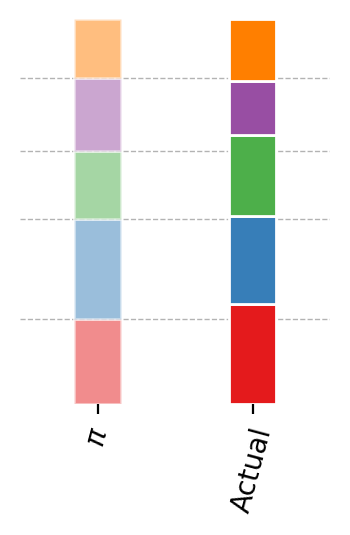

In [47]:

true_dist = theta.pi()
compare_dist = jnp.histogram(latents.z, jnp.arange(arch.N+1) - 0.5, density = True)[0]

fig, ax = plt.subplots(figsize = (2, 2.5))

mixtures.compare_dirichlet_blocks(true_dist, compare_dist, ax, labels = [r'$\pi$', "Actual"])
plt.show()



Array([0.26, 0.23, 0.21, 0.14, 0.16], dtype=float32)